In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage import measure
from os import listdir,path
import os
from skimage import io
import torch
from dataloaders import Dataset_color
from Ctorch import *
from WienerCNN import WienerFunction
from torch import nn as nn
torch.cuda.set_device(2)
from supplementary import *

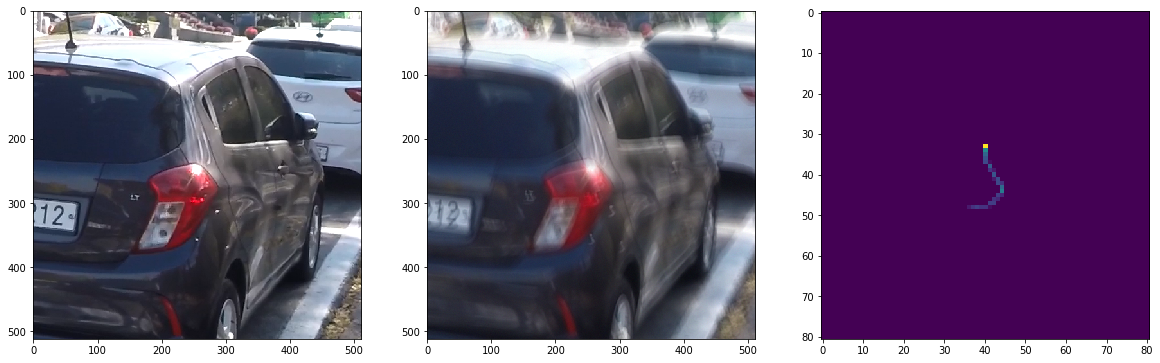

In [15]:
testset = Dataset_color('dataset/',img_size=(512,512),train=False);
(x,y,k,l) = testset[100];
fig,ax=plt.subplots(1,3,figsize=(20,60));
ax[0].imshow(x.permute(1,2,0));
ax[1].imshow(y.permute(1,2,0));
ax[2].imshow(k[0,:,:]);

In [ ]:
def compute_valloss_cuda(model,x,y,k,lam):
    batch_net = model((y.cuda(),k.cuda(),lam.cuda())).detach();
    x_cuda = x.cuda();
    y_cuda = y.cuda();

    loss = 10*torch.log10((1/nn.functional.mse_loss(batch_net[:,:,(k.shape[2]-1)//2:-(k.shape[2]-1)//2,(k.shape[3]-1)//2:-(k.shape[3]-1)//2],x.cuda())));
    compare  = -10*torch.log10((1/nn.functional.mse_loss(,x.cuda())));
    return loss;
def validate(model,valloader):
    valloss = [];
    compare = [];
    for i_batch, (x,y,k,l) in enumerate((valloader)):
            # obtaining loss
            valloss.append(compute_loss_cuda(model,x,y,k,l).detach().cpu());
            compare = loss = -10*torch.log10((1/nn.functional.mse_loss(,x.cuda())));
        valloss = -np.mean(valloss);

In [2]:
from torch.autograd import Variable, gradcheck

y = Variable(torch.rand(2,1,32,32).double(), requires_grad=True).cuda();
k = torch.rand(2,1,5,5).double().cuda();
k = k/(torch.sum(torch.sum(k, dim=3), dim=2)[:,:,None,None]).cuda();
k = Variable(k.double(), requires_grad=False)
lam = Variable(torch.rand(1).double(), requires_grad=True).cuda().squeeze(0);
weights = torch.rand(3,1,3,3).cuda();
weights = weights/(torch.sum(torch.sum(weights, dim=3), dim=2)[:,:,None,None]);
weights = Variable(weights.double(), requires_grad=True)

#test = gradcheck(WienerFunction.apply, (y, k, lam, weights), eps=1e-6, atol=1e-4);
#print(test)